# RoundU
## LDA para recomendaciones en Twitter

Para empezar, importamos las bibliotecas básicas

In [1]:
import re
import gensim as gns
import nltk
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pyodbc 

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

Y el archivo de configuración local

In [2]:
import configLocal

server = configLocal.server
database = configLocal.database
username = configLocal.username
password = configLocal.password
cnxn = configLocal.cnxn
cursor = cnxn.cursor()

## Descarga de datos

Traigo a memoria los datos que hemos recogido de twitter en Azure

In [3]:
data = pd.read_sql_query("select msg_id, msg_users_id, msg_timestamp, msg_text from dbo.msg", cnxn)

Formo un diccionario con todos los tweet asociados a sus respectivos ids de usuario de twitter

In [4]:
corpus = {}
for i in range(data.shape[0]):
    if data.iloc[i]["msg_users_id"] in corpus:
        corpus[data.iloc[i]["msg_users_id"]].append(data.iloc[i]["msg_text"])
    else:
        corpus[data.iloc[i]["msg_users_id"]] = [data.iloc[i]["msg_text"]]

        
len(corpus)

7157

## Definiciones de funciones

In [5]:
def getTokensCorpusDiccionario(textList):
    """
    Get messages tokenized, the bow corpus and the id2word dictionary

    Parameters:
    ----------
    textList : List of strings

    Returns:
    -------
    token_lists_list : List of the token lists which represent a string
    bow_corpus : Corpus of vectors prepared for LDA
    dictionary : id2word necessary to understand the corpus
    """
    listOfListsOfTokens = []
    for text in textList:
        vector = preprocess(text)
        listOfListsOfTokens.append(vector)

    dictionary = gns.corpora.Dictionary(listOfListsOfTokens)
    bow_corpus = [dictionary.doc2bow(listOfTokens) for listOfTokens in listOfListsOfTokens]

    return (listaDeListaDeTokens, bow_corpus, dictionary)

In [6]:
def preprocess(text):
    """
    Preprocces raw text before using it in NLP algorithm

    Parameters:
    ----------
    text : String

    Returns:
    -------
    result : List of string tokens got from the original string
    """
    text = dropUrls(text)
    result=[]
    #resultString = ""
    for token in gns.utils.simple_preprocess(text) :
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in nltk.corpus.stopwords.words('spanish') and len(token) > 3:
            lemmatized = lemmatize_stemming(token)
            result.append(lemmatized)
            #resultString += " " + lematizado            
    return result

In [7]:
def dropUrls(text):
    """
    Drop urls from string

    Parameters:
    ----------
    text : String

    Returns:
    -------
    result : Original string without urls
    """
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

In [8]:
def lemmatize_stemming(text):
    """
    Text

    Parameters:
    ----------
    text : String

    Returns:
    -------
    result : List of string tokens got from the original string
    """
    for frequentLemma in frequentLemmas:
        if text == frequentLemma[1]:
            return frequentLemma[0]
    
    foundLemma = lemmatization.loc[lemmatization["palabra"] == text].iloc[0].get("lexema") if sum(lemmatization["palabra"] == text) > 0 else text
    frequentLemmas.append([foundLemma, text])
    return foundLemma

lemmatization = pd.read_csv("/media/marc/Ubuntu_home/marc/MasterDataScience/RoundURepo2/LexemasEspanol", sep="\t", header=None, names=['lexema', 'palabra'])
frequentLemmas = []

In [9]:
for frequentLemmas in frequentLemmas:
    print(frequentLemmas)

In [10]:
def save_object(obj, filename):
    """
    Saves a Python object in disk to be reloaded later

    Parameters:
    ----------
    ojb : Python object
    filemane : Name or path in the file system
    """
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [11]:
def load_object(filename):
    """
    Loads a Python object, previously saved to the disk

    Parameters:
    ----------
    filename : Name or path in the file system

    Returns:
    -------
    result : Python object loaded
    """
    with open(filename, 'rb') as myFile:
        loadedFile = pickle.load(myFile)
    return loadedFile

In [12]:
def computeTextTopic(model, text):
    """
    Gets the probability of each category for the given text, by the given model

    Parameters:
    ----------
    model : LSA model
    texts : List of strings

    Returns:
    -------
    result : Python object loaded
    """
    token_lists_list = [preprocess(text)]
    dictionary2 = gns.corpora.Dictionary(token_lists_list)
    bow_corpus2 = [dictionary2.doc2bow(listaDeTokens) for listaDeTokens in token_lists_list]
    topics = model.get_document_topics(bow_corpus2[0])
    return topics

In [13]:
def userTopicsTweets(model, texts):
    """
    Gets the topic of each one the texts, with the given model

    Parameters:
    ----------
    model : LSA model
    texts : List of strings

    Returns:
    -------
    main_topic : The id of the most scored topic for each one of the texts
    """
    positions = []
    for text in texts:
        topic = computeTextTopic(model, text)
        position = 0
        value = 0
        for (positionTopic, valueTopic) in topic:
            if valueTopic > value:
                value = valueTopic
                position = positionTopic
        positions.append(position)
    return positions

In [14]:
def compute_coherence_values(models, texts, dictionary, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    i= 0
    for num_topics in tqdm(range(start, limit, step)):
        #model = gns.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(models[i])
        
        coherencemodel = gns.models.CoherenceModel(model=models[i], texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        i += 1

    return model_list, coherence_values


def showCoherencePlot(tokens, models, dictionary, limit, start, step):
    
    model_list, coherence_values = compute_coherence_values(models=models, texts=tokens, dictionary=dictionary, start=start, limit=limit, step=step)
    #limit=40; start=2; step=6;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [15]:
def differenceBetweenTwoUserByTopics(topics1, topics2):
    """
    Gets the computed value of difference between two lists of topics

    Parameters:
    ----------
    topics1 : List of int
    topics2 : List of int

    Returns:
    -------
    difference : Value of difference
    """
    difference = 0
    topics1.sort()
    list1Counted = []
    topics2.sort()
    list2Counted = []
    
    list1Counted = _differenceBetweenTwoUserByTopics_1(topics1, 0, 0)
    sum1 = sum(list1Counted)
    list1Percentages = []
    for item in list1Counted:
        list1Percentages.append(item/sum1)

    list2Counted = _differenceBetweenTwoUserByTopics_1(topics2, 0, 0)
    sum2 = sum(list2Counted)
    list2Percentages = []
    for item in list2Counted:
        list2Percentages.append(item/sum2)
        
    if len(list1Percentages) < len(list2Percentages):
        for i in range(len(list2Percentages) - len(list1Percentages)):
            list1Percentages.append(0)
            
    if len(list2Percentages) < len(list1Percentages):
        for i in range(len(list1Percentages) - len(list2Percentages)):
            list2Percentages.append(0)
        
    for i in range(len(list1Percentages)):
        difference += abs(list1Percentages[i] - list2Percentages[i])

    return difference


def _differenceBetweenTwoUserByTopics_1(lista, number, counter):
    if len(lista) == 0:
        return [counter]
    if lista[0] != number:
        return [counter] + _differenceBetweenTwoUserByTopics_1(lista, number + 1, 0)
    else:
        return _differenceBetweenTwoUserByTopics_1(lista[1:], number, counter + 1)

In [16]:
def difference1ToNByTopics(user, manyUsers):
    """
    Gets the computed values of differences between one list of topics and many other lists of topics

    Parameters:
    ----------
    user : List of int
    manyUsers : List of lists of int

    Returns:
    -------
    difference : List of values of difference
    """
    results = []
    for user2 in manyUsers:
        results.append([user2[0], differenceBetweenTwoUserByTopics(user, user2[1])])
        
    return results

In [17]:
def differenceNByTopics(manyUsers):
    """
    Gets the computed values of differences between many lists of topics

    Parameters:
    ----------
    manyUsers : List of lists of int

    Returns:
    -------
    difference : List of values of difference
    """
    results = []
    for i, user1 in enumerate(manyUsers):
        for difference in difference1ToNByTopics(user1[1], manyUsers[i+1:]):
            results.append([user1[0], difference[0], difference[1]])        
            
    return results

def differenceNToNByTopics(manyUsers1, manyUsers2):
    results = []
    for user1 in manyUsers1:
        for difference in difference1ToNByTopics(user1[1], manyUsers2):
            results.append([user1[0], difference[0], difference[1]])        
            
    return results

## Tratamiento de los datos con LDA

### Creación del modelo LDA

Para generar el modelo LDA, vamos a usar todos los tweets, sin tener en cuenta el autor. 

In [18]:
tweets = []

for item in list(corpus.items()):
    for tweet in item[1]:
        tweets.append(tweet)

En primer lugar necesitamos convertir todos los mensajes a tokens. En este preprocesado se convierten las palabras en objetos string separados, y se filtran para eliminar las stopwords. También se lexematiza cada una de las palabras, para conseguir un conjunto más uniforme en base al significado, y tratar a todas las variantes o conjugaciones de cada palabra como si fueran una sola

In [ ]:
#Solo es necesario la primera vez, ahora ya lo tenemos creado. Tarda más de una hora con la muestra de 45000

#(tokens, bow_corpus, dictionary) = getTokensCorpusDiccionario(tweets)

Como es un proceso largo, lo guardamos en disco

In [ ]:
#Se guarda solo la primera vez. Ya lo tenemos guardado

#save_object((tokens, bow_corpus, dictionary), "TokensBowAndDictionary")

Y lo volvemos a cargar en memoria para trabajar tantas veces como queramos

In [19]:
(tokens, bow_corpus, dictionary) = load_object("TokensBowAndDictionary")

Ahora creamos el modelo de LDA. Tenemos que indicarle cuántas categorías queremos que establezca. En principio no lo sabemos, así que creamos varios modelos

In [ ]:
# NO EJECUTAR
#Solo se ejecuta la primera vez porque tiene un componente aleatorio

#lda_model19 = gns.models.LdaModel(bow_corpus, num_topics=19, id2word=dictionary)
#lda_model24 = gns.models.LdaModel(bow_corpus, num_topics=24, id2word=dictionary)
#lda_model29 = gns.models.LdaModel(bow_corpus, num_topics=29, id2word=dictionary)
#lda_model34 = gns.models.LdaModel(bow_corpus, num_topics=34, id2word=dictionary)
#lda_model39 = gns.models.LdaModel(bow_corpus, num_topics=39, id2word=dictionary)
#lda_model44 = gns.models.LdaModel(bow_corpus, num_topics=44, id2word=dictionary)
#lda_model49 = gns.models.LdaModel(bow_corpus, num_topics=49, id2word=dictionary)
#lda_model54 = gns.models.LdaModel(bow_corpus, num_topics=54, id2word=dictionary)
#lda_model59 = gns.models.LdaModel(bow_corpus, num_topics=59, id2word=dictionary)
#lda_model64 = gns.models.LdaModel(bow_corpus, num_topics=64, id2word=dictionary)
#lda_model69 = gns.models.LdaModel(bow_corpus, num_topics=69, id2word=dictionary)
#lda_model74 = gns.models.LdaModel(bow_corpus, num_topics=74, id2word=dictionary)

El proceso es largo y además tiene un componente aleatorio, así que, una vez hechos, no nos interesa volver a ejecutar la creación de cada uno. Los guardamos en disco

In [ ]:
#Se guardan solo la primera vez. Ya los tenemos guardados

#save_object(lda_model19, "LDA19")
#save_object(lda_model24, "LDA24")
#save_object(lda_model29, "LDA29")
#save_object(lda_model34, "LDA34")
#save_object(lda_model39, "LDA39")
#save_object(lda_model44, "LDA44")
#save_object(lda_model49, "LDA49")
#save_object(lda_model54, "LDA54")
#save_object(lda_model59, "LDA59")
#save_object(lda_model59, "LDA64")
#save_object(lda_model69, "LDA69")
#save_object(lda_model74, "LDA74")

Y los cargamos a memoria

In [20]:
modelsToTest = [
    load_object("LDA19"),
    load_object("LDA24"),
    load_object("LDA29"),
    load_object("LDA34"),
    load_object("LDA39"),
    load_object("LDA44"),
    load_object("LDA49"),
    load_object("LDA54"),
    load_object("LDA59"),
    load_object("LDA64"),
    load_object("LDA69"),
    load_object("LDA74")
]

Vamos a usar el coeficiente de coherencia para saber cuán coherentes son los modelos. Dibujamos el coeficiente de coherencia

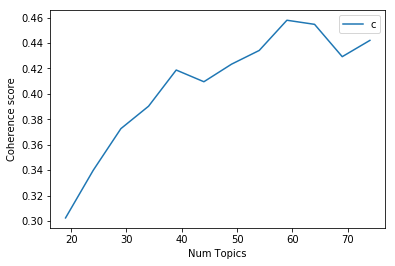

In [21]:
showCoherencePlot(tokens, modelsToTest, dictionary, 75, 19, 5)

Parece que la coherencia llega a su tope alrededor de 59 categorías.
Vamos a visualizar el contenido de este modelo

In [22]:
lda_model59 = modelsToTest[8]

visual59 = pyLDAvis.gensim.prepare(lda_model59, bow_corpus, dictionary)
visual59

/home/marc/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
46     0.162576  0.155834       1        1  3.083670
5      0.206896 -0.075128       2        1  2.940678
34     0.044657  0.044614       3        1  2.567985
20    -0.010777 -0.176961       4        1  2.388067
39     0.094794 -0.197951       5        1  2.372336
16     0.089232 -0.079149       6        1  2.183447
0      0.006232 -0.087710       7        1  2.176425
57     0.009020  0.055384       8        1  2.086780
14     0.093502  0.103861       9        1  2.042324
12     0.106341  0.001313      10        1  2.036945
29     0.116116  0.000596      11        1  2.009889
31     0.016837  0.056204      12        1  1.963285
48     0.085507 -0.025791      13        1  1.948662
23    -0.073279 -0.029939      14        1  1.943152
9      0.033239 -0.012110      15        1  1.887646
27    -0.001958 -0.099322      16        1  1.880690
42     0.050191 -0.069522      17        1  1.866961
40     0.079841  0.054228      18        1  1.844386
50     0.116480  0.086554      19        1  1.836710
47    -0.006908 -0.053956      20        1  1.818464
26    -0.044248  0.009742      21        1  1.818231
43     0.019144 -0.018596      22        1  1.802184
4      0.017040 -0.027660      23        1  1.750410
24    -0.032509  0.033170      24        1  1.739128
51     0.038139 -0.026130      25        1  1.715139
49    -0.073427 -0.028403      26        1  1.701316
11     0.003634  0.063500      27        1  1.696303
10     0.021792  0.022527      28        1  1.677481
54    -0.041588 -0.063448      29        1  1.651837
33     0.031974 -0.073950      30        1  1.641138
28    -0.023351  0.063459      31        1  1.633555
17     0.019228  0.033805      32        1  1.629511
25    -0.067144  0.012164      33        1  1.586298
35    -0.003472  0.041749      34        1  1.564333
2      0.048882 -0.034755      35        1  1.559426
22     0.040930  0.061378      36        1  1.549326
18     0.096271  0.064685      37        1  1.546117
3     -0.038132 -0.035697      38        1  1.498141
21    -0.017917  0.029082      39        1  1.496062
13    -0.080356  0.023270      40        1  1.463575
6     -0.033821 -0.030153      41        1  1.446203
44    -0.072684  0.039384      42        1  1.440598
1     -0.022560  0.050389      43        1  1.404628
15    -0.057110  0.026493      44        1  1.392208
38    -0.028467  0.024052      45        1  1.389805
30    -0.066856  0.010725      46        1  1.388278
8     -0.050075  0.042481      47        1  1.355918
52    -0.062344 -0.023380      48        1  1.344631
56    -0.046352 -0.005397      49        1  1.308562
37    -0.022842 -0.052226      50        1  1.306904
53    -0.073206  0.024110      51        1  1.295698
41    -0.052178  0.009215      52        1  1.293221
36    -0.085307  0.018782      53        1  1.282953
58    -0.054783  0.026375      54        1  1.275445
55    -0.048821 -0.016032      55        1  1.216822
7     -0.105726  0.001343      56        1  1.172036
32    -0.079619  0.025109      57        1  1.071789
19    -0.098609 -0.001934      58        1  1.034199
45    -0.072066  0.029724      59        1  0.982094, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
187   Default  4047.000000    barcelona  4047.000000  30.0000  30.0000
14    Default  2736.000000        bueno  2736.000000  29.0000  29.0000
127   Default  2758.000000       gracia  2758.000000  28.0000  28.0000
87    Default  2733.000000       querer  2733.000000  27.0000  27.0000
350   Default  2265.000000        pasar  2265.000000  26.0000  26.0000
150   Default  1671.000000       seguir  1671.000000  25.0000  25.0000
48    Default  1741.000000        mejor  1741.000000  24.0000  24.0000
286   Default  1787.000000        saber  1787.000000  23.0000  23.0000
103   Default 

Pero se ve mejor distribuido el modelo de 64 categorías, y la coherencia también es buena

In [23]:
lda_model64 = modelsToTest[9]

visual64 = pyLDAvis.gensim.prepare(lda_model64, bow_corpus, dictionary)
visual64

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
41    -0.116729 -0.012316       1        1  2.428169
28    -0.113322 -0.128735       2        1  2.389027
46    -0.120335  0.107204       3        1  2.349791
38    -0.098698 -0.127539       4        1  2.324145
31    -0.081690 -0.123078       5        1  2.287653
47    -0.036089 -0.140707       6        1  2.287414
63    -0.155543  0.082208       7        1  2.245111
13    -0.065091  0.011520       8        1  2.227166
12    -0.042861 -0.112175       9        1  2.131512
48    -0.096743 -0.099297      10        1  2.051694
37    -0.029557  0.094823      11        1  2.011563
62     0.035941 -0.055538      12        1  2.010494
14    -0.106530  0.088710      13        1  1.991829
44     0.015331  0.026274      14        1  1.959526
30    -0.147577  0.002661      15        1  1.936782
57    -0.071632 -0.007516      16        1  1.930064
36    -0.133728  0.030100      17        1  1.831083
9     -0.019724 -0.094447      18        1  1.820042
59    -0.038755  0.015264      19        1  1.751077
2     -0.089870  0.035334      20        1  1.748389
51    -0.057050  0.013986      21        1  1.723477
18    -0.006052 -0.068527      22        1  1.689883
33    -0.043090  0.056524      23        1  1.659295
15    -0.080442  0.031702      24        1  1.647195
5     -0.063811  0.030280      25        1  1.642520
45    -0.008410  0.070560      26        1  1.641842
17     0.041162 -0.056731      27        1  1.569491
21    -0.018562 -0.045652      28        1  1.557212
50     0.067846 -0.042057      29        1  1.525002
43    -0.050616  0.071623      30        1  1.519385
...         ...       ...     ...      ...       ...
6     -0.026466  0.041015      35        1  1.439126
7      0.049414 -0.050877      36        1  1.430294
52     0.038010 -0.041522      37        1  1.418839
0      0.057354 -0.039631      38        1  1.393273
40     0.018809 -0.052104      39        1  1.370453
39     0.004675  0.149648      40        1  1.349020
4      0.011877  0.014170      41        1  1.338688
1      0.025713 -0.005807      42        1  1.337016
58     0.057252 -0.030726      43        1  1.329325
19     0.074588  0.011230      44        1  1.314173
61     0.042211 -0.046404      45        1  1.313664
27     0.042392  0.020940      46        1  1.299234
32     0.039128 -0.040436      47        1  1.243069
26     0.087354 -0.021976      48        1  1.238966
35     0.070003 -0.030326      49        1  1.230105
55     0.024729  0.037572      50        1  1.229293
11     0.067287  0.049877      51        1  1.226337
10     0.049023  0.037590      52        1  1.225648
8      0.062517 -0.033129      53        1  1.197324
29     0.052286 -0.030289      54        1  1.158459
23     0.055076 -0.011783      55        1  1.150489
54     0.081085  0.035740      56        1  1.123668
42     0.071966  0.008876      57        1  1.107737
3      0.096394  0.001347      58        1  1.096382
22     0.075585  0.058754      59        1  1.050221
34     0.092298  0.025746      60        1  1.007895
56     0.105476 -0.014714      61        1  0.996399
20     0.080191  0.049176      62        1  0.940941
49     0.098424  0.043292      63        1  0.842062
24     0.121027  0.000247      64        1  0.779916

[64 rows x 5 columns], topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
187   Default  4090.000000        barcelona  4090.000000  30.0000  30.0000
127   Default  2744.000000           gracia  2744.000000  29.0000  29.0000
330   Default  3525.000000            decir  3525.000000  28.0000  28.0000
14    Default  2636.000000            bueno  2636.000000  27.0000  27.0000
87    Default  2517.000000           querer  2517.000000  26.0000  26.0000
350   Default  2366.000000            pasar  2366.000000  25.0000  25.

Consultamos el valor de alpha para ajustar la visualización

In [24]:
lda_model64.alpha[0]

0.015625

### Uso del modelo LDA

Ahora que hemos escogido el modelo LDA con 64 categorías, vamos a pedirle que clasifique en temas cada uno de los tweets de cada usuario

In [129]:
#Solo es necesario la primera vez. Lleva tiempo en ejecutar

#temasDeUsuarios = [[usuario, userTopicsTweets(lda_model64, corpus[usuario])] for usuario in tqdm(list(corpus.keys()))]

Guardamos los temas obtenidos a disco

In [130]:
#Solo lo guardamos la primera vez. Ya está guardado

#save_object(temasDeUsuarios, "UsersAndTopics")

Cargamos

In [25]:
temasDeUsuarios = load_object("UsersAndTopics")

### Análisis de semejanza de usuarios

Vamos a borrar de la lista a quienes tengan solamente 3 o menos tweets, su muestra es muy pequeña o no son usuarios activos

In [26]:
temasDeUsuariosActivos = []
for temasDeUsuario in temasDeUsuarios:
    if len(temasDeUsuario[1]) > 3:
        temasDeUsuariosActivos.append(temasDeUsuario)

len(temasDeUsuarios), len(temasDeUsuariosActivos)

(7157, 2128)

Averiguamos cual es el grado de diferencia en las preferencias, en cuanto a categorías semánticas, que muestra cada usuario con los demás.
Usamos todos los usuarios y los mensajes que tenemos registrados

In [27]:
diferencias = pd.DataFrame(differenceNByTopics(temasDeUsuariosActivos[:100]), columns=["Id1", "Id2", "Difference"])

diferencias.sort_values("Difference")

,Id1,Id2,Difference
574,3356423908,3001797008,0.000000
3821,974022020,124181440,0.000000
1319,182574375,222258601,0.000000
1320,182574375,2263351042,0.000000
1324,182574375,876440612484132865,0.000000
1326,182574375,67048775,0.000000
1327,182574375,94427376,0.000000
1328,182574375,3051098118,0.000000
1329,182574375,384266897,0.000000
1331,182574375,974022020,0.000000


Para hallar las semejanzas de cada usuario con nuevos usuarios que podemos registrar en el futuro, hacemos la prueba importando otro corpus desde un .csv

In [28]:
data2 = pd.read_csv("stream_e.csv", sep="ef5r64i")[["Texto", "IdUsuario"]]

corpus2 = {}

for i in range(data2.shape[0]):
    if data2.iloc[i]["IdUsuario"] in corpus2:
        corpus2[data2.iloc[i]["IdUsuario"]].append(data2.iloc[i]["Texto"])
    else:
        corpus2[data2.iloc[i]["IdUsuario"]] = [data2.iloc[i]["Texto"]]
        
tweets2 = []

for item in list(corpus2.items()):
    for tweet in item[1]:
        tweets2.append(tweet)

corpus2 = {}

for i in range(1, 101):
    corpus2[str(i)] = tweets2[((i*10) - 10):(i*10)]

/home/marc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


Y como en el anterior, le pedimos al modelo, que clasifique en categorías todos los mensajes de estos nuevos usuarios

In [29]:
temasDeUsuarios2 = [[usuario, userTopicsTweets(lda_model64, corpus2[usuario])] for usuario in tqdm(list(corpus2.keys()))]

Y averiguamos cual es el grado de diferencia de estos con los otros usuarios, para saber a quienes podríamos recomendar

In [30]:
diferenciasConNuevos = pd.DataFrame(differenceNToNByTopics(temasDeUsuariosActivos[:100], temasDeUsuarios2), columns=["Id1", "Id2", "Difference"])

diferenciasConNuevos.sort_values("Difference")

,Id1,Id2,Difference
5140,974022020,41,0.000000
6731,214920130,32,0.000000
6730,214920130,31,0.000000
6728,214920130,29,0.000000
996,1076303250,97,0.000000
6727,214920130,28,0.000000
994,1076303250,95,0.000000
993,1076303250,94,0.000000
6724,214920130,25,0.000000
6735,214920130,36,0.000000


También podemos comparar un solo usuario nuevo con los demás, si es lo que necesitamos

In [31]:
temasDelNuevo = userTopicsTweets(lda_model64, ["Me como una docena de churros cada día y engordo",
                               "Busco piso pero barato porque no tengo trabajo", "Doy clases de ingles desde casa por videoconferencia"])

diferenciasConElNuevo = pd.DataFrame(difference1ToNByTopics(temasDelNuevo, temasDeUsuariosActivos), columns=["Id", "Difference"])

diferenciasConElNuevo.sort_values("Difference")

,Id,Difference
990,43560411,0.000000
782,733220549544054784,0.000000
1505,271680853,0.000000
784,51948717,0.000000
1503,18131304,0.000000
1502,124016777,0.000000
787,2851027833,0.000000
1501,1085917669713502211,0.000000
1500,1384140349,0.000000
790,714544433572741120,0.000000
